# Ess 330 Project Updates

Chippy Marx (CSU)  
Chris Drew (CSU)

# Methods

**Data importing and initial cleaning**

Before we could do any of our analysis, we had to import our projected spatial data, and extract the raster values from it. The historic invasive species data we had did not have latitude and longitude, which was important for  analysis, so we found a dataset that had these values and shared site identifier values. We did an inner-join on these two datasets, and then selected only the attributes we would need for analysis to make the dataset smaller, filtered to the year we were interested in (2007), and removed missing values.  We had to prepare the spatial point data with the extracted raster values by filtering and formatting the dataset so that it was clean. Then, we  transformed the coordinate system of our historic data in order to match that of the raster data , or our projected dataset. Next we extracted the raster values from our projected dataset for the sites we had in our historic data set. We then binded these extracted values with the points in our historic dataset to create a new dataset where each row had both spatial and raster-derived information.

In [ ]:
library(tidyverse)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.2     ✔ tibble    3.2.1
✔ lubridate 1.9.4     ✔ tidyr     1.3.1
✔ purrr     1.0.4     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

── Attaching packages ────────────────────────────────────── tidymodels 1.2.0 ──
✔ broom        1.0.7     ✔ rsample      1.2.1
✔ dials        1.3.0     ✔ tune         1.2.1
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.1.0
✔ parsnip      1.2.1     ✔ yardstick    1.3.2
✔ recipes      1.1.0     
── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks readr::spec()
✖ recipes::step()   masks stats::step()
• Use tidymodels_prefer() to resolve common conflicts.

terra 1.8.42

Attaching package: 'terra'

The following object is masked from 'package:scales':

    rescale

The following object is masked from 'package:tidyr':

    extract

Linking to GEOS 3.13.0, GDAL 3.8.5, PROJ 9.5.1; sf_use_s2() is TRUE

In [ ]:
# bring in forb data 
r <- rast(c(
  "data/sl_forb_current.tiff",
  "data/sl_forb_mid_585.tiff",
  "data/sl_forb_late_585.tiff"
))

#bring in grass data 
g <- rast(c('data/sl_grass_current.tiff','data/sl_grass_late_585.tiff', 'data/sl_grass_mid_585.tiff' ))


# Load and join historic  data
Invasive_data <- read_csv("data/CO_INVASIVE_SUBPLOT_SPP.csv")

Rows: 3975 Columns: 17
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr   (2): VEG_FLDSPCD, VEG_SPCD
dbl  (13): CN, PLT_CN, INVYR, STATECD, UNITCD, COUNTYCD, PLOT, SUBP, CONDID,...
lgl   (1): MODIFIED_DATE
dttm  (1): CREATED_DATE

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.

Rows: 29168 Columns: 24
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr   (3): ECOSUBCD, ROADLESSCD, FVS_VARIANT
dbl  (16): CN, STATECD, INVYR, UNITCD, COUNTYCD, PLOT, LAT, LON, CONGCD, HUC...
lgl   (3): FVS_DISTRICT, ECO_UNIT_PNW, PRECIPITATION
dttm  (2): CREATED_DATE, MODIFIED_DATE

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.

**Test 1: Visualizations**

In [ ]:
#sites we will select, project
site_ids = c(12224885010690, 12221198010690, 12223803010690, 12206792010690, 12222071010690, 1223416010690, 12225851010690, 12232600010690, 12212814010690,     12214073010690  ) 

#filer spatial data to only include the 10 sites of interest, then reproject. 
ex_pts = pts %>% 
  filter(PLT_CN %in% site_ids) %>% 
  st_transform(crs(r))

#extract raster values and bind comlums 
v <-  extract(r, ex_pts)
ex_Pts_both = bind_cols(ex_pts, v)

#do the same for grass data 
ex_pts_g = pts %>% 
  filter(PLT_CN %in% site_ids) %>% 
  st_transform(crs(g))

g <-  extract(g, ex_pts_g)
ex_Pts_both_g = bind_cols(ex_pts_g, g)

ex_pts = pts %>% 
  filter(PLT_CN %in% site_ids) %>% 
  #distinct() %>% 
  st_transform(crs(r))

v <-  extract(r, ex_pts)
ex_Pts_both = bind_cols(ex_pts, v)

#point of this is ... for forb 
df_long <- ex_Pts_both %>%
  select(ID, COVER_PCT, sl_forb_current, sl_forb_mid_585, sl_forb_late_585) %>%
  pivot_longer(
    cols = c(COVER_PCT, sl_forb_current, sl_forb_mid_585, sl_forb_late_585),
    names_to = "variable",
    values_to = "value"
  )

#for grass 
df_long_g <- ex_Pts_both_g %>%
  select(ID, COVER_PCT, sl_grass_current, sl_grass_mid_585, sl_grass_late_585) %>%
  pivot_longer(
    cols = c(COVER_PCT, sl_grass_current, sl_grass_mid_585, sl_grass_late_585),
    names_to = "variable",
    values_to = "value"
  )

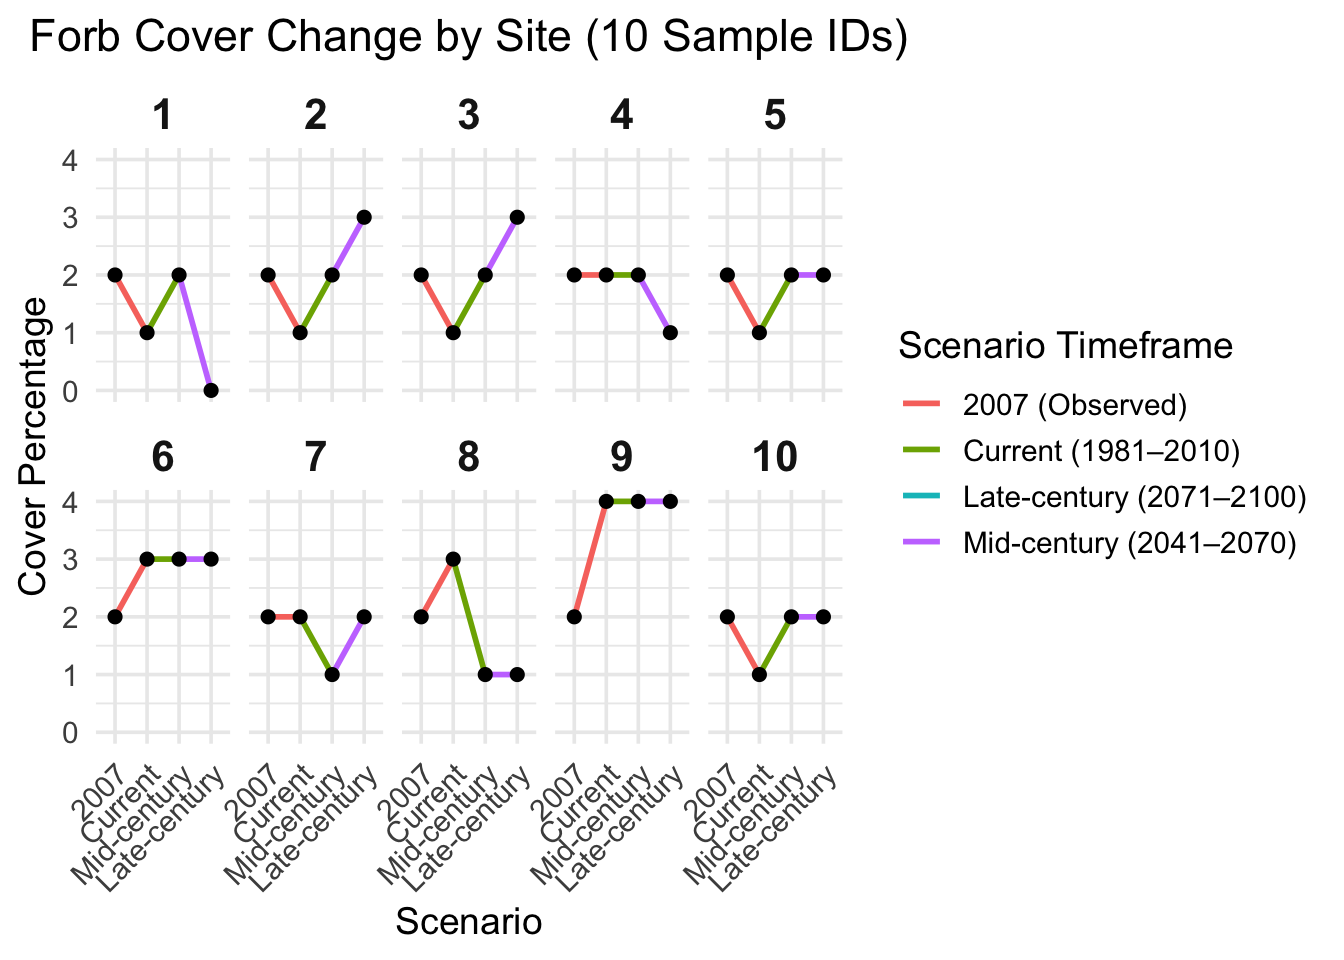

In [ ]:
# Filter to 10 unique IDs
ten_ids_forb <- df_long %>% 
  distinct(ID) %>%
  slice_head(n = 10) %>%
  pull(ID)

df_subset_forb <- df_long %>%
  filter(ID %in% ten_ids_forb)

# Convert ID to factor to preserve facet order
df_subset_forb$ID <- factor(df_subset_forb$ID)

df_subset_forb <- df_subset_forb %>%
  mutate(
    variable = recode(variable,
      "COVER_PCT" = "2007 (Observed)",
      "sl_forb_current" = "Current (1981–2010)",
      "sl_forb_mid_585" = "Mid-century (2041–2070)",
      "sl_forb_late_585" = "Late-century (2071–2100)"
    ),
    scenario_label = case_when(
      variable == "2007 (Observed)" ~ "2007",
      variable == "Current (1981–2010)" ~ "Current",
      variable == "Mid-century (2041–2070)" ~ "Mid-century",
      variable == "Late-century (2071–2100)" ~ "Late-century",
      TRUE ~ NA_character_  # catch unmatched cases
    ),
    scenario_label = factor(scenario_label, levels = c("2007", "Current", "Mid-century", "Late-century"))
  ) %>%
  filter(!is.na(scenario_label))  # drop rows with NA scenario_label

# Plot
ggplot(df_subset_forb, aes(x = scenario_label, y = value, group = ID)) +
  geom_line(aes(color = variable), linewidth = 1) +
  geom_point(size = 2) +
  facet_wrap(~ ID, scales = "fixed", nrow = 2) +
  labs(
    x = "Scenario",
    y = "Cover Percentage",
    title = "Forb Cover Change by Site (10 Sample IDs)",
    color = "Scenario Timeframe"
  ) +
  theme_minimal(base_size = 14) +
  theme(
    axis.text.x = element_text(angle = 45, hjust = 1),
    strip.text = element_text(size = 16, face = "bold"),
    plot.title = element_text(hjust = 0.5)
  )

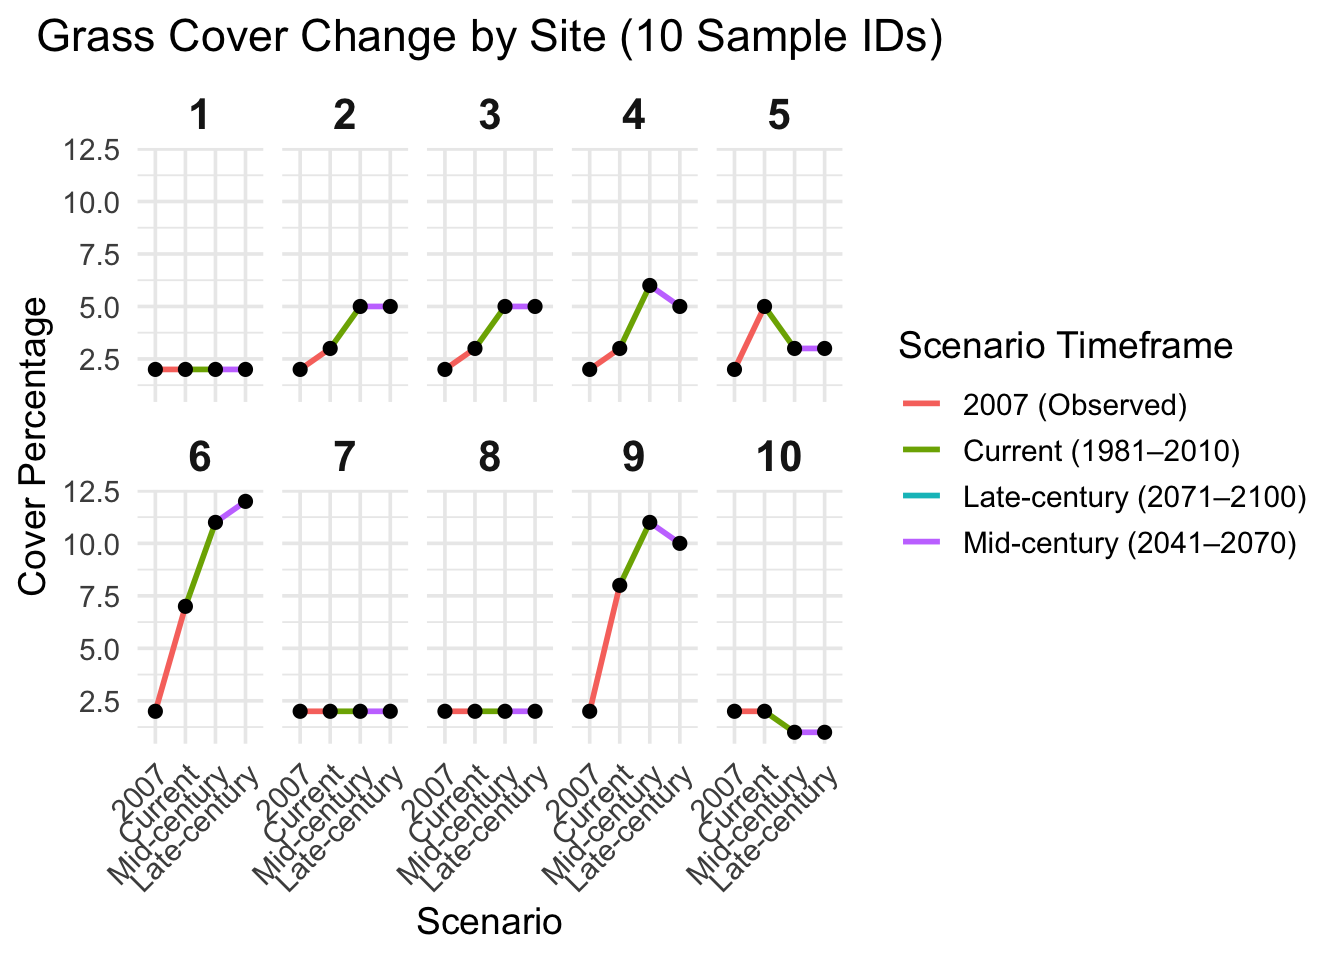

In [ ]:
# Filter to 10 unique IDs
ten_ids <- df_long_g %>% 
  distinct(ID) %>%
  slice_head(n = 10) %>%
  pull(ID)

df_subset <- df_long_g %>%
  filter(ID %in% ten_ids)

# Convert ID to factor to control facet order and labels
df_subset$ID <- factor(df_subset$ID)

df_subset_grass <- df_subset %>%
  mutate(
    # Detailed labels for the legend
    variable = recode(variable,
      "COVER_PCT" = "2007 (Observed)",
      "sl_grass_current" = "Current (1981–2010)",
      "sl_grass_mid_585" = "Mid-century (2041–2070)",
      "sl_grass_late_585" = "Late-century (2071–2100)"
    ),
    # Simplified x-axis labels
    scenario_label = case_when(
      variable == "2007 (Observed)" ~ "2007",
      variable == "Current (1981–2010)" ~ "Current",
      variable == "Mid-century (2041–2070)" ~ "Mid-century",
      variable == "Late-century (2071–2100)" ~ "Late-century",
      TRUE ~ NA_character_
    ),
    # Ensure factor order on x-axis
    scenario_label = factor(scenario_label, levels = c("2007", "Current", "Mid-century", "Late-century"))
  ) %>%
  filter(!is.na(scenario_label))  # remove any unmatched

# Plot
ggplot(df_subset_grass, aes(x = scenario_label, y = value, group = ID)) +
  geom_line(aes(color = variable), linewidth = 1) +
  geom_point(size = 2) +
  facet_wrap(~ ID, scales = "fixed", nrow = 2) +
  labs(
    x = "Scenario",
    y = "Cover Percentage",
    title = "Grass Cover Change by Site (10 Sample IDs)",
    color = "Scenario Timeframe"
  ) +
  theme_minimal(base_size = 14) +
  theme(
    axis.text.x = element_text(angle = 45, hjust = 1),
    strip.text = element_text(size = 16, face = "bold"),
    plot.title = element_text(hjust = 0.5)
  )

**Building the reference map**

For these figures we wanted to create a reference map of where the 10 sites we chose were. To do this we laid our 10 sites (using their lat and long values) on a map of Colorado. Next, we added the labels of the sites to the data set. We had to transform the location values back to lat and lon as we had projected them in the coordinate system of our spatial data earlier. We then plotted this onto our map of Colorado.

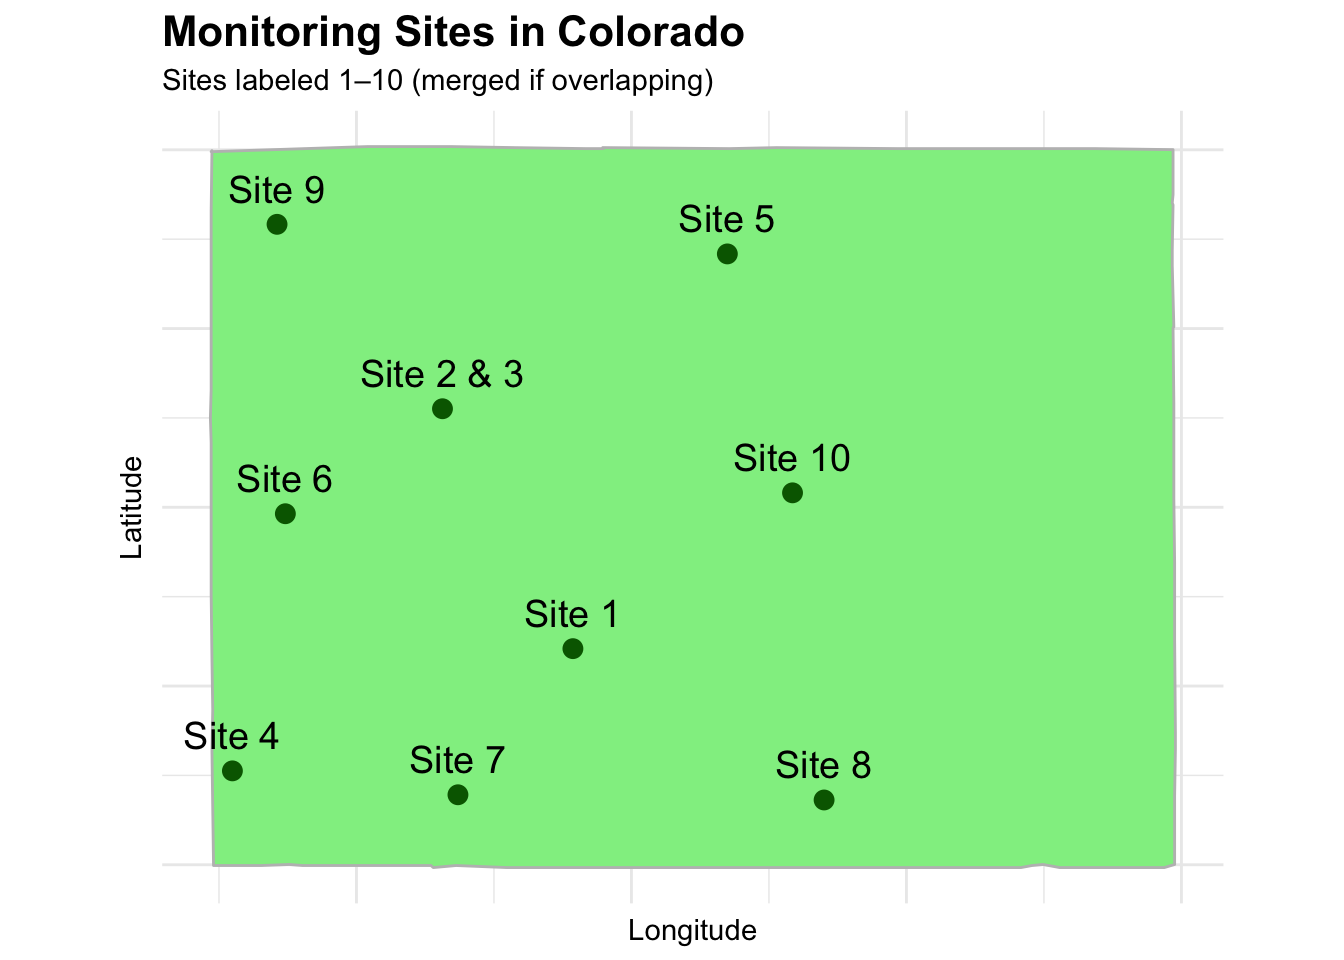

In [ ]:
# Get US state boundaries from base R maps
usa <- map_data("state")

# Filter for Colorado
colorado <- usa %>% filter(region == "colorado")

# Step 1: Add labels BEFORE converting to lat/lon
ex_pts$Label <- as.character(1:nrow(ex_pts))

# Step 2: Transform to lat/lon and extract coordinates
ex_pts_latlon <- st_transform(ex_pts, crs = 4326) %>% 
  mutate(
    lon = st_coordinates(.)[, 1],
    lat = st_coordinates(.)[, 2]
  ) %>%
  st_drop_geometry()

# Step 3: Group overlapping points and combine labels
ex_pts_latlon_grouped <- ex_pts_latlon %>%
  group_by(lon, lat) %>%
  summarise(Label = paste0("Site ", paste(Label, collapse = " & ")), .groups = "drop")

# Step 4: Plot
ggplot() +
  geom_polygon(data = colorado, aes(x = long, y = lat, group = group),
               fill = "lightgreen", color = "grey") +
  geom_point(data = ex_pts_latlon_grouped, aes(x = lon, y = lat), color = "darkgreen", size = 3) +
  geom_text(data = ex_pts_latlon_grouped, aes(x = lon, y = lat, label = Label), 
            nudge_y = 0.2, size = 5) +
  coord_fixed(1.3) +
  labs(title = "Monitoring Sites in Colorado", subtitle = "Sites labeled 1–10 (merged if overlapping)",
       x = "Longitude", y = "Latitude") +
  theme_minimal() +
  theme(
    plot.title = element_text(size = 16, face = "bold"),
    axis.text = element_blank(),
    axis.ticks = element_blank()
  )

**Test 2: Machine Learning**

The second test we are doing  is a machine learning model in order to train a model to predict the percent cover of invasive forbs in the projected late century (2080–2100) cover data  from our historic cover data, the projected “current” cover (1981-2010), and the projected mid-century cover (2040–2060).  While we are not done with this model, we have taken several steps so far. 

 When we cleaned this dataset and created our combined historic and projected datasets for the machine learning, to ensure useful group-level analysis, we grouped the data by the classification in the late century dataset, counted the number of observations in each group, and filtered the data to retain only groups with more than 2 observations. We did this because models do not like to predict values that only occur once in the dataset. After ungrouping the data, we prepared it for modeling by converting the cover percentages in both the historic and projected data to factor type, as we saw that classification engines in the models worked better. 

Next, we set a seed, did the initial split on our data, and set resamples for modeling. We had to drop the geometry in our dataset, as the models we chose do not support spatial data. We then defined our recipe as described above. 

We chose 3 candidate models: random forest (RF)(with a ranger engine), Xgboost (Xgb) (with a xgboost engine), and a multilayer perceptron (MLP)  (with a neural network engine) model. For all of these models, the mode was set at classification because our data, while numeric values, is categorical not continuous.  We chose the RF model because it handles missing data and outliers well. We chose the Xgb model because it is one of the best models in predictive taste, especially for structured data. We chose the MLP model because it can model complex, nonlinear patterns between predictors and outcomes, and it was suggested to us because of the nature of our data . For each model we defined a workflow.  Next, we defined our list of models for comparison, and set the comparison metrics as Kappa and Accuracy. Accuracy measures the proportion of correctly classified observations out of all observations, and Kappa is a  measure of agreement between the predicted and actual classifications, adjusted for chance agreement (the level of agreement between predicted and actual classifications that would be expected just by random guessing).

We then got stuck with our analysis, as we need to do more data manipulation and model adjustments before we can run out models. The next steps include making a workflow set with all the models, fitting the workflows with cross-validation, and comparing the models based on our comparison metrics. Once we know which model performs best, we can pick a model, tune that model, find the best hyperparameters, and finalize the workflow, getting predictions. 

We do not know if we have chosen appropriate methods for this analysis yet, as we cannot see any performance metrics until we work out the kinks in our dataset and machine learning methods.

In [ ]:
ex_pts_Ml = pts %>% 
  st_transform(crs(r))

v2<-  extract(r, ex_pts_Ml)

ex_Pts_ml_both <- bind_cols(ex_pts_Ml, v2) %>% 
  group_by(sl_forb_late_585) %>% 
  mutate(n = n()) %>% 
  ungroup() %>% 
  filter(n > 2) %>% 
  mutate(
    sl_forb_current = as.factor(sl_forb_current),
    sl_forb_mid_585 = as.factor(sl_forb_mid_585),
    sl_forb_late_585 = as.factor(sl_forb_late_585),  
    COVER_PCT = as.factor(COVER_PCT)
  ) 

ex_Pts_ml_both$sl_forb_late_585 %>% table()

.
 0  1  2  3  4 
15 68 27 13  4 

In [ ]:
#set seed, split data
set.seed(32)
ex_pts_both_split <- initial_split(ex_Pts_ml_both, prop = 0.8, strata = sl_forb_late_585)
ex_pts_train <- training(ex_pts_both_split)
ex_pts_test  <- testing(ex_pts_both_split)

#resamples 
ex_both_cv <- vfold_cv(ex_pts_train, v=10)

#more cleaning 
ex_Pts_ml_df <- ex_Pts_ml_both %>%
  st_drop_geometry()

# Then define your recipe
forb_recipe <- recipe(sl_forb_late_585 ~ sl_forb_mid_585 + sl_forb_current + COVER_PCT, data = ex_Pts_ml_df) %>%
  step_naomit(all_predictors(), all_outcomes()) %>%
  step_normalize(all_numeric_predictors())

table(ex_Pts_ml_df$sl_forb_late_585)


 0  1  2  3  4 
15 68 27 13  4 

# A tibble: 127 × 4
   sl_forb_mid_585 sl_forb_current COVER_PCT sl_forb_late_585
   <fct>           <fct>           <fct>     <fct>           
 1 1               2               2         2               
 2 0               0               2         0               
 3 2               2               2         1               
 4 1               1               2         1               
 5 1               1               2         1               
 6 1               1               2         1               
 7 1               1               2         1               
 8 1               1               2         1               
 9 1               3               2         1               
10 1               3               2         1               
# ℹ 117 more rows

In [ ]:
#define 3 candidate models and set workflows 

rf_mod <- rand_forest(trees = 500, mtry = 2) %>%
  set_engine("ranger") %>%
  set_mode("classification")

rf_wf <- workflow() %>%
  add_model(rf_mod) %>%
  add_recipe(forb_recipe)

xgb_mod <- boost_tree(trees = 500, learn_rate = 0.1) %>%
  set_engine("xgboost") %>%
  set_mode("classification")

xgb_wf <- workflow() %>%
  add_model(xgb_mod) %>%
  add_recipe(forb_recipe)

nn_mod <- mlp()%>%
  set_engine("nnet")%>%
  set_mode("classification")

nn_wf <- workflow() %>% 
  add_model(nn_mod) %>% 
  add_recipe(forb_recipe)

**Where we get stuck**

In [ ]:
#define list of models for comparison 
#model_list <- list(
 # MLP= nn_mod,
  #random_forest = rf_mod,
  #xgboost = xgb_mod
#)

#define my metrics 
#my_metrics <- metric_set

#create workflow set with all models 
#wf_set <- workflow_set(
 # preproc = list(forb = forb_recipe),
 # models = model_list
#)
#fit all worklows with cross-validation 
#wf_results <- wf_set %>%
  #workflow_map(resamples = ex_both_cv, metrics = my_metrics, verbose = TRUE)

#next we would autoplot but this is where we got stuck after meeting with Mike and changing things around. 

In [ ]:
#specify tunable parameters 
#xgb_mod_tuned <- boost_tree(
  #trees = tune(),
  #learn_rate = tune(),
  #tree_depth = tune()
#) %>%
  #set_engine("xgboost") %>%
  #set_mode("classification")

#create new workflow 
#xgb_wf_tuned <- workflow() %>%
  #add_model(xgb_mod_tuned) %>%
  #add_recipe(forb_recipe)

#define tunable grid
#xgb_grid <- grid_regular(
  #trees(range = c(100, 1000)),
  #learn_rate(range = c(0.01, 0.3)),
  #tree_depth(range = c(2, 10)),
  #levels = 5
#)
#tune model with cross-validation
#xgb_tuned_results <- tune_grid(
  #xgb_wf_tuned,
  #resamples = ex_both_cv,
  #grid = xgb_grid,
  #metrics = my_metrics,
  #control = control_grid(save_pred = TRUE)
#)

In [ ]:
#evaluate and select the best model 
#best_xgb <- select_best(xgb_tuned_results, metric = "accuracy")

#show_best(xgb_tuned_results)

#autoplot(xgb_tuned_results)

In [ ]:
#finalize workflow with the best hyperparameters 
#final_xgb_wf <- finalize_workflow(xgb_wf_tuned, best_xgb)

#final model veriication 
#final_xgb_last <- last_fit(
  #final_xgb_wf,
  #split = ex_pts_both_split
#)
# Collect performance metrics
#collect_metrics(final_xgb_last)
#collect predictions 
#final_xgb_preds <- collect_predictions(final_xgb_last)

In [ ]:
#names(final_xgb_preds)

In [ ]:
#ggplot(final_xgb_preds, aes(x = .pred, y = sl_forb_late_585)) +
  #geom_point(alpha = 0.6, color = "steelblue") +
  #geom_abline(slope = 1, intercept = 0, linetype = "dashed", color = "red") +
  #labs(
    #x = "Predicted",
   # y = "Actual",
  #  title = "Predicted vs. Actual - Final XGBoost Model"
 # ) +
 # theme_minimal()

# Results

# Discussion